# Visualizing conda-forge travis data

Data was collected from travis API and stored in sqlite.

Only do this first part once.
It takes a while to load the data from sqlite.
Then store it in parquet via pyarrow.

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
%aimport aiotravis

In [3]:
!du -hs travis.sqlite

494M	travis.sqlite


In [4]:
%time builds = aiotravis.load_builds('conda-forge')

CPU times: user 20.4 s, sys: 470 ms, total: 20.9 s
Wall time: 22.7 s


In [5]:
%time jobs = aiotravis.load_jobs('conda-forge')

CPU times: user 45.9 s, sys: 942 ms, total: 46.8 s
Wall time: 50.9 s


Save the data to arrow for quicker loads in the future

In [6]:
import pyarrow as pa
import pyarrow.parquet as pq

In [7]:
%%time
build_arrow = pa.Table.from_pandas(builds)
pq.write_table(build_arrow, 'builds.parquet')
job_arrow = pa.Table.from_pandas(jobs)
pq.write_table(job_arrow, 'jobs.parquet')

CPU times: user 217 ms, sys: 34.2 ms, total: 251 ms
Wall time: 249 ms


In [8]:
!du -hs *.parquet

2.8M	builds.parquet
5.2M	jobs.parquet


# Start here

Start here if the data is already downloaded and saved to parquet.

In [9]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

In [10]:
%%time
builds = all_builds = pq.read_table('builds.parquet').to_pandas()
jobs = all_jobs = pq.read_table('jobs.parquet').to_pandas()

CPU times: user 160 ms, sys: 44 ms, total: 204 ms
Wall time: 198 ms


In [11]:
import matplotlib.pyplot as plt
plt.ion()

`builds` is all the builds with their number and start/finish/create dates and duration. Same for `jobs`.

In [12]:
# only retrieve jobs that ran (start to finish)
builds = builds[builds.started.notnull() & builds.finished.notnull()]
builds.tail()

,org,name,number,state,started,finished,created,duration
75837,conda-forge,tyssue-feedstock,7,failed,2018-01-29 13:29:21+00:00,2018-01-29 13:40:45+00:00,2018-01-29 13:21:10+00:00,624.0
75838,conda-forge,cppzmq-feedstock,12,passed,2018-01-29 13:54:00+00:00,2018-01-29 13:57:22+00:00,2018-01-29 13:23:57+00:00,202.0
75841,conda-forge,staged-recipes,25642,passed,2018-01-29 15:52:39+00:00,2018-01-29 15:58:27+00:00,2018-01-29 13:41:59+00:00,348.0
75842,conda-forge,staged-recipes,25647,passed,2018-01-29 16:23:54+00:00,2018-01-29 16:31:02+00:00,2018-01-29 13:47:07+00:00,428.0
75843,conda-forge,r-rjava-feedstock,5,failed,2018-01-29 16:12:42+00:00,2018-01-29 16:23:19+00:00,2018-01-29 13:48:39+00:00,604.0


In [13]:
# only retrieve jobs that ran (start to finish)
jobs = jobs[jobs.started.notnull() & jobs.finished.notnull()]
jobs.tail()

,org,name,build,number,state,started,finished,created
164923,conda-forge,staged-recipes,25745,1,passed,2018-01-29 21:54:33+00:00,2018-01-29 21:59:54+00:00,2018-01-29 15:30:47.249000+00:00
164925,conda-forge,staged-recipes,25747,1,passed,2018-01-29 22:05:07+00:00,2018-01-29 22:11:29+00:00,2018-01-29 15:31:52.005000+00:00
164926,conda-forge,staged-recipes,25748,1,passed,2018-01-29 22:06:25+00:00,2018-01-29 22:11:37+00:00,2018-01-29 15:32:31.071000+00:00
164927,conda-forge,staged-recipes,25749,1,passed,2018-01-29 22:12:30+00:00,2018-01-29 22:18:53+00:00,2018-01-29 15:33:07.654000+00:00
164931,conda-forge,staged-recipes,25753,1,passed,2018-01-29 23:34:49+00:00,2018-01-29 23:38:44+00:00,2018-01-29 16:32:24.782000+00:00


Create month column by rounding start date down to the month,
and give jobs a 'duration' field to match builds.

In [14]:
jobs['month'] = jobs.started.apply(
    lambda ts: pd.Timestamp(year=ts.year, month=ts.month, day=1)
)
builds['month'] = builds.started.apply(
    lambda ts: pd.Timestamp(year=ts.year, month=ts.month, day=1)
)
# store job duration to match builds
jobs['duration'] = (jobs.finished - jobs.started).apply(lambda ts: ts.total_seconds())

/Users/benjaminrk/dev/ip/kernel/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/benjaminrk/dev/ip/kernel/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/benjaminrk/dev/ip/kernel/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
jobs.state.value_counts()

passed      118559
failed       23833
errored       6950
canceled      1616
Name: state, dtype: int64

Some jobs have negative runtime. This is usually when their build has been cancelled.
Drop these

In [16]:
jobs[jobs.duration < 0].state.value_counts()

canceled    590
passed       46
failed       27
errored       8
Name: state, dtype: int64

In [17]:
jobs = jobs[jobs.duration >= 0]
jobs.state.value_counts()

passed      118513
failed       23806
errored       6942
canceled      1026
Name: state, dtype: int64

In [18]:
builds = builds[builds.duration >= 0]
builds.state.value_counts()

passed      48462
failed      15616
errored      3339
canceled      809
Name: state, dtype: int64

Total builds and jobs, by month

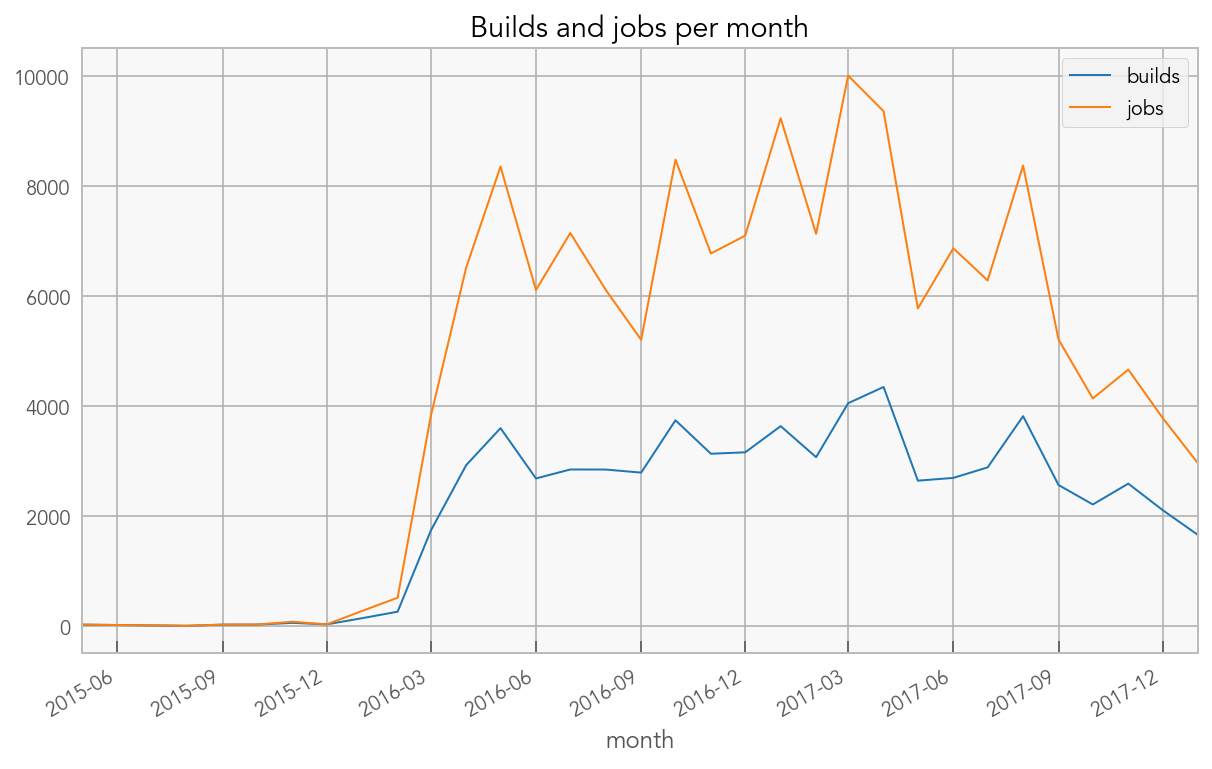

In [19]:
together = builds.groupby(builds.month).duration.count().plot(label='builds')
jobs.groupby(jobs.month).duration.count().plot(label='jobs')
plt.legend(loc=0)
plt.title("Builds and jobs per month");

##  Timing info

We can plot the time spent on jobs.
First, we get the total build time per month, then a distribution of the build time in quantiles.

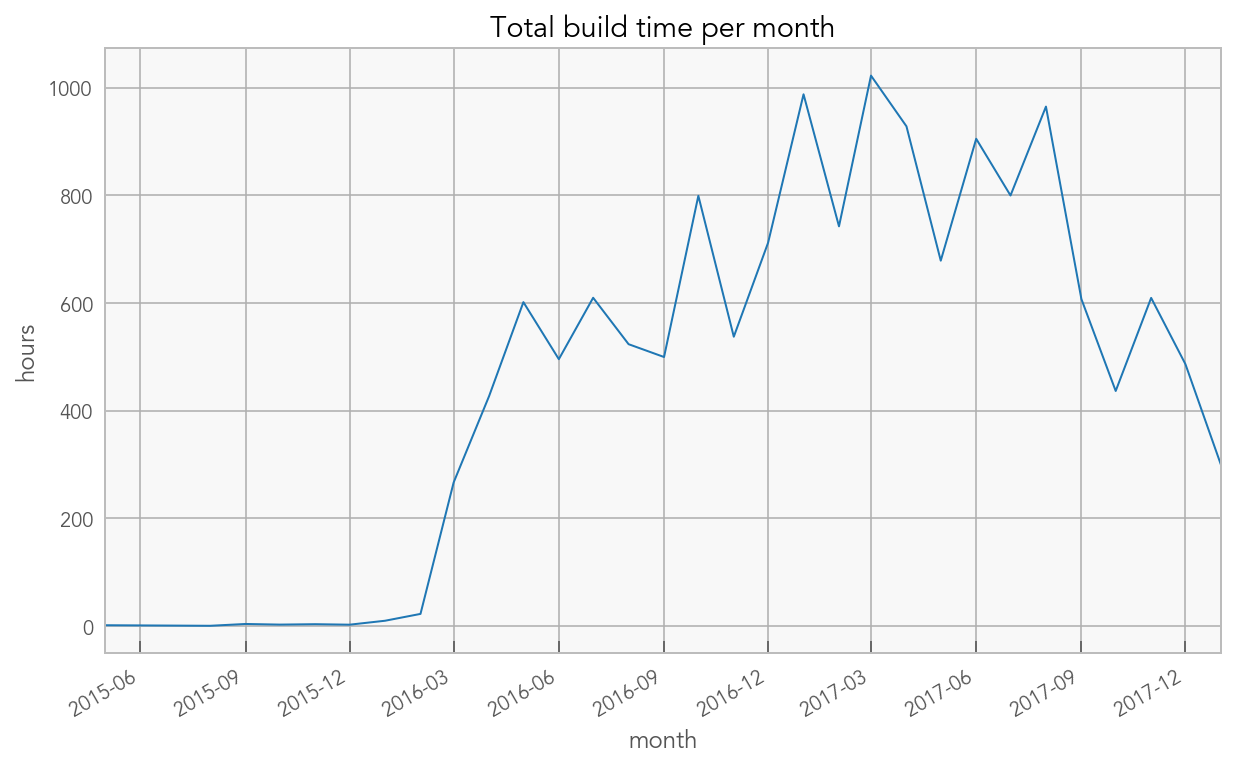

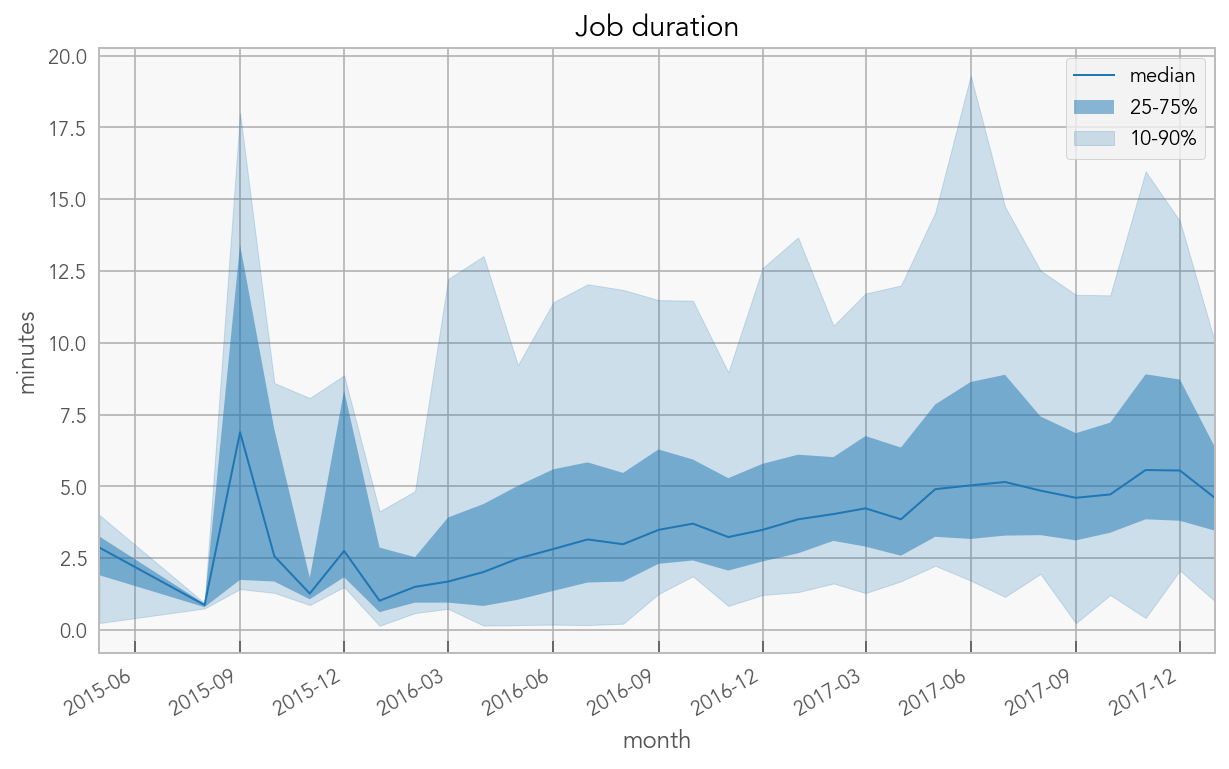

In [20]:
def plot_quantiles(duration):
    plt.title("Job duration")
    plt.ylabel('minutes')
    q = duration.quantile([0.1, 0.25, 0.5, 0.75, 0.9]) / 60
    median = q[:,0.5]
    median.plot(label='median')
    x = median.index
    fill = plt.fill_between(x, q[:,0.25], q[:,0.75],
                            alpha=0.5, label='25-75%')
    plt.fill_between(x, q[:,0.1], q[:,0.9],
                     alpha=0.2, color=fill.get_facecolor(),
                     label='10-90%')
    plt.legend(loc=0)
    
def plot_times(jobs, column='duration'):
    """Plot distribution of build times"""
    duration = jobs.groupby(jobs.month)[column]
    plt.title("Total build time per month")
    (duration.sum() / 3600).plot()
    plt.ylabel('hours')
    plt.figure()
    plot_quantiles(duration)

plot_times(jobs)    

So a typical job will run for five minutes, 75% finish in less than ten minutes, and 90% finish in less than 20.

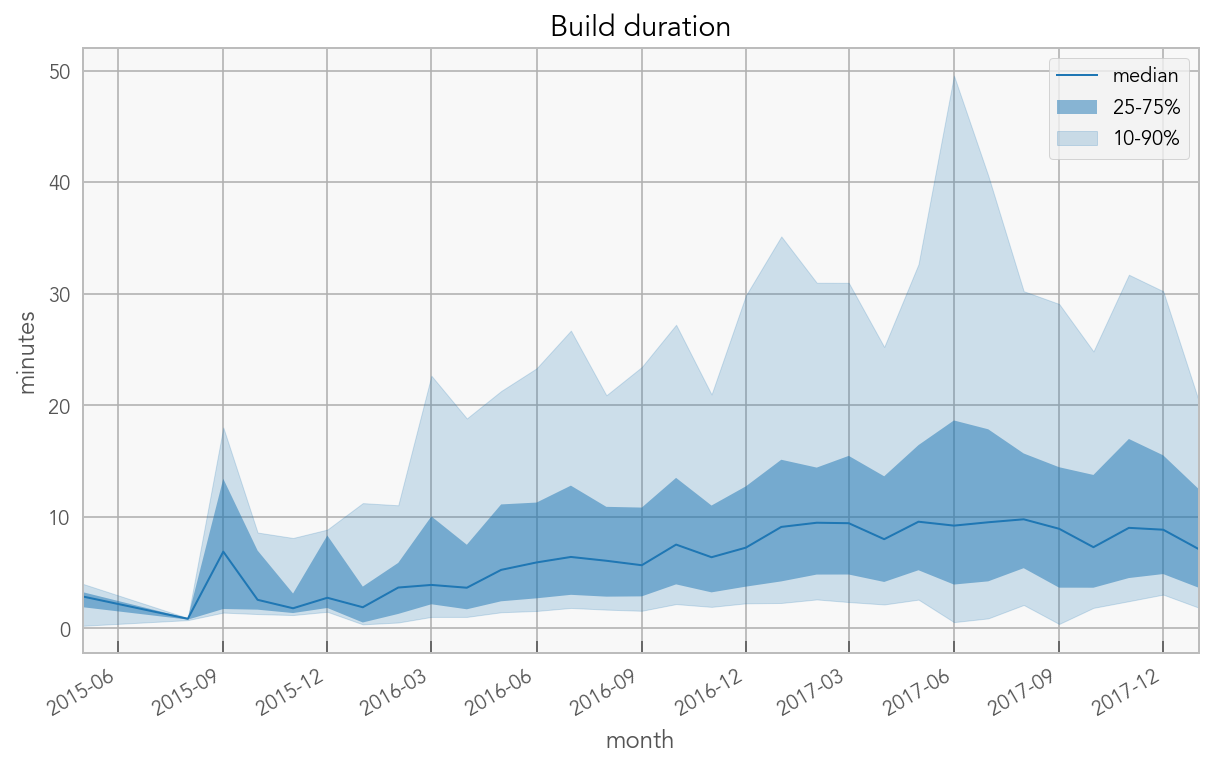

In [21]:
plot_quantiles(builds.groupby('month').duration)
plt.title("Build duration");

We can see how much time we are spending in a given job, based on what status it will end up in.
The vast majority of time is spent in successful builds.

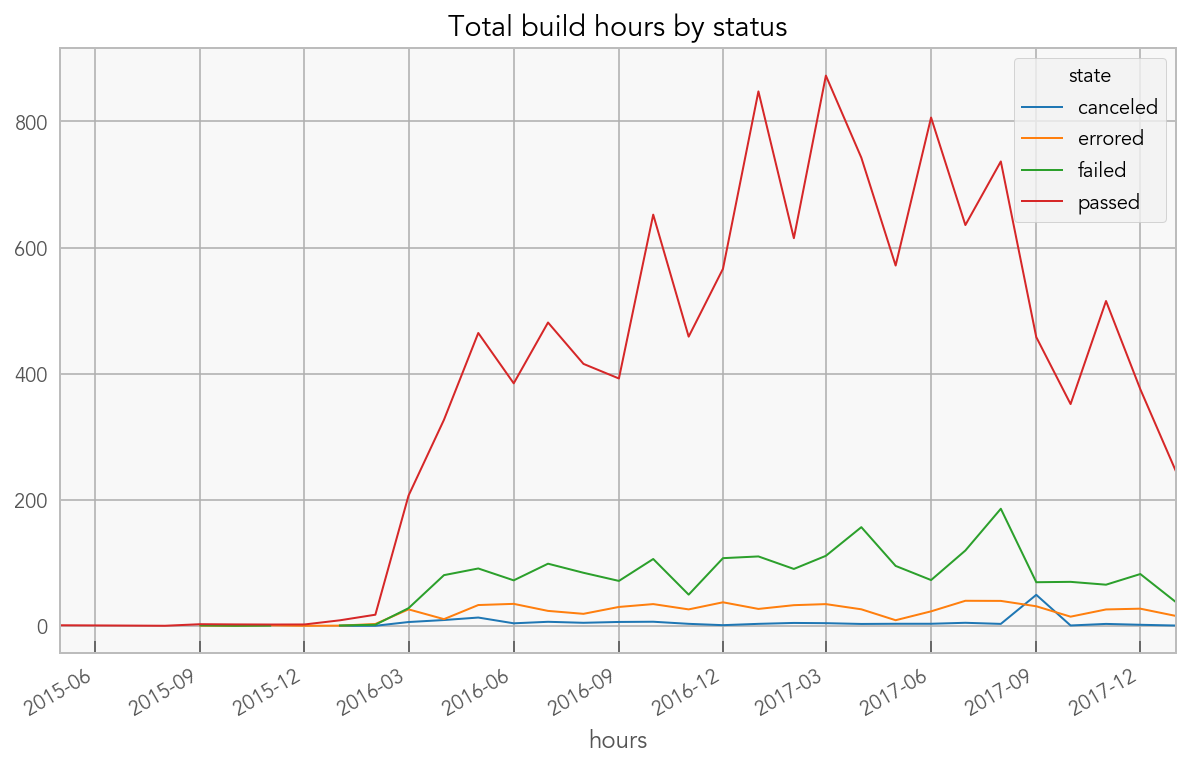

In [22]:
(jobs.groupby([jobs.state, jobs.month]).duration.sum() / 3600).unstack().T.plot()
plt.title("Total build hours by status")
plt.xlabel("hours");

## Queue wait times

We can also plot wait times for jobs and builds.
The build wait time is the time from when the build is created to the start of its first job. The job wait time is the time for each job from when it is created to when it starts (strictly longer than build wait, since one build may queue several jobs).

/Users/benjaminrk/dev/ip/kernel/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


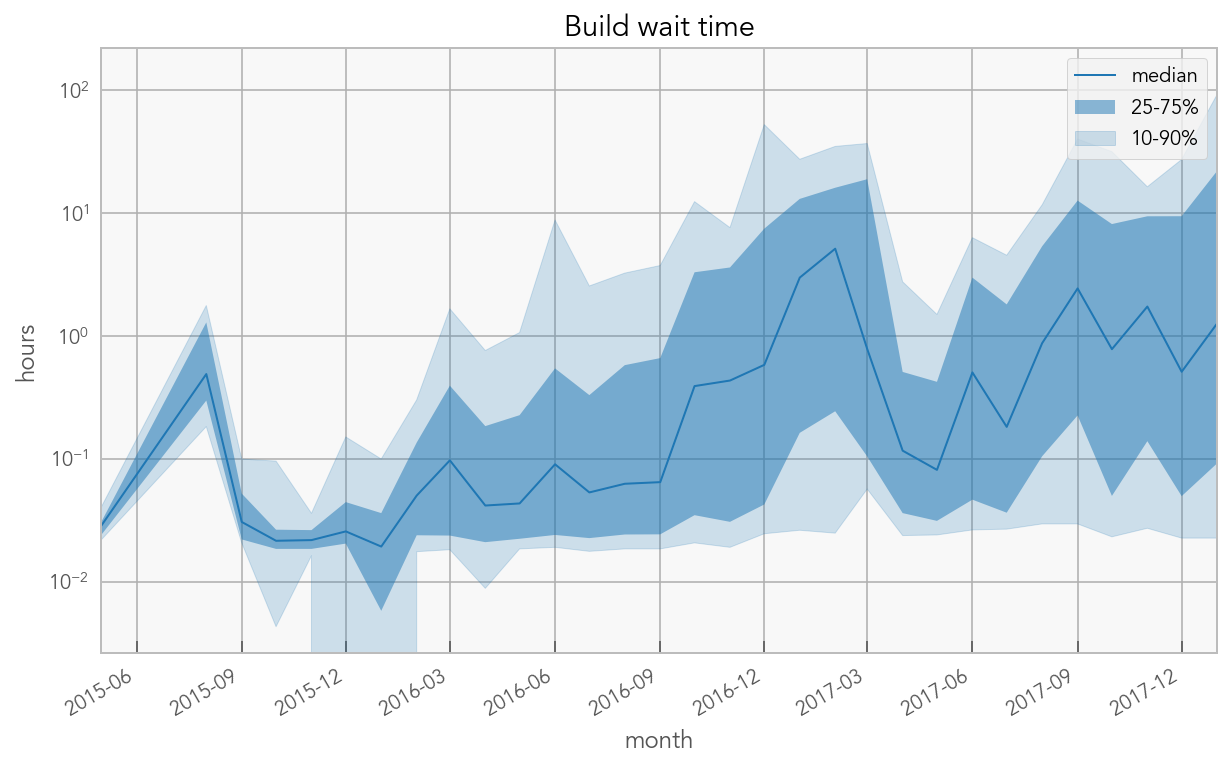

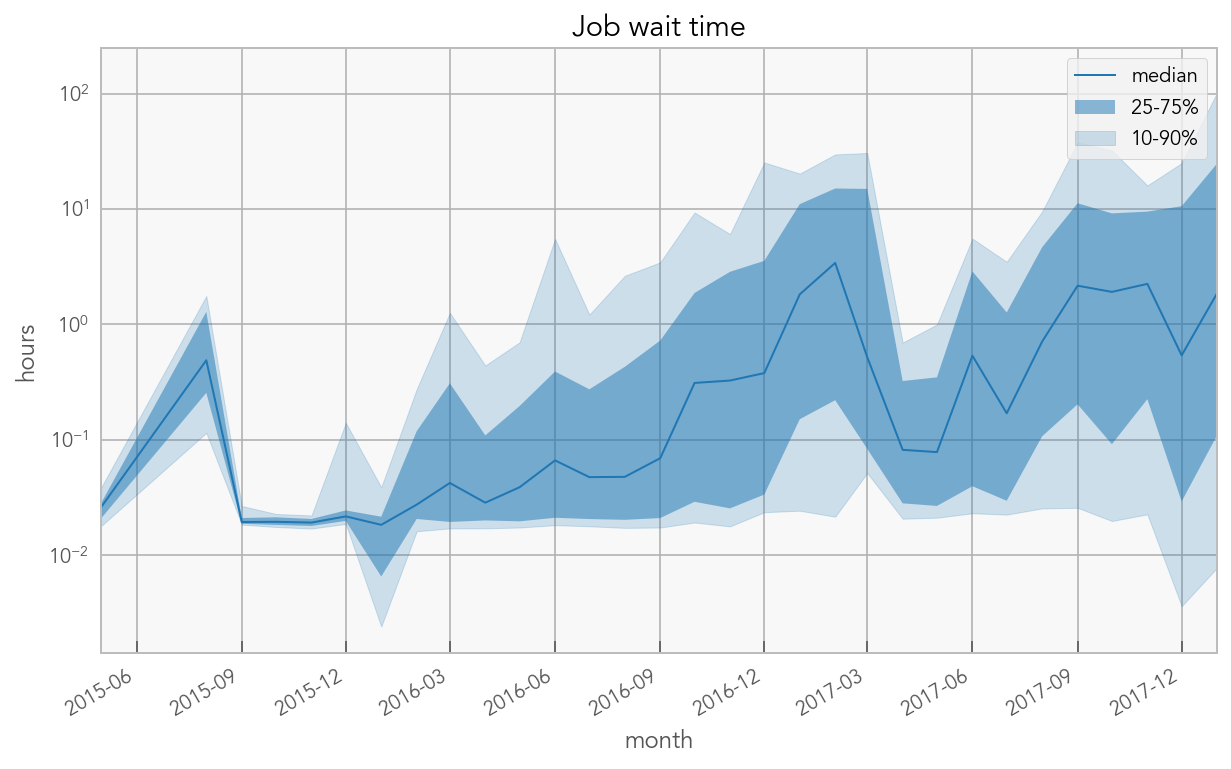

In [23]:
def plot_waits(df, title='wait time'):
    df = df[df.created.notnull()]
    df['waits'] = (df.started - df.created).apply(lambda ts: ts.total_seconds())
    waits = df.groupby(df.month)['waits']
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.set_ylabel('hours')
    q = waits.quantile([0.1, 0.25, 0.5, 0.75, 0.9]) / 3600
    median = q[:,0.5]
    median.plot(label='median')
    x = median.index
    fill = ax.fill_between(x, q[:,0.25], q[:,0.75],
                            alpha=0.5, label='25-75%')
    ax.fill_between(x, q[:,0.1], q[:,0.9],
                     alpha=0.2, color=fill.get_facecolor(),
                     label='10-90%')
    ax.legend(loc=0)
    ax.set_yscale('log')
    # cutoff 90th percentile by limiting
    ax.set_ylim(None, 10 * q[:,0.75].max())

plot_waits(builds, 'Build wait time')
plot_waits(jobs, 'Job wait time')